In [1]:
!pip install nltk

In [2]:
%config Completer.use_jedi = False

In [100]:
import re
from datetime import datetime

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import nltk
from nltk import wordpunct_tokenize, WordNetLemmatizer, SnowballStemmer
from nltk.corpus import stopwords

In [14]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/imd/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/imd/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [6]:
df = pd.read_csv("train.csv")

In [7]:
df.head()

,name,review,game,platform,score,date,ID
0,GameSpy,Sporting some of the best writing and voice wo...,Portal 2,PC,100.0,"Apr 22, 2011",6
1,DarkZero,"In conclusion, Portal 2 is a textbook example ...",Portal 2,PC,100.0,"Apr 21, 2011",7
2,Destructoid,"Without a doubt, one of the best games ever ma...",Portal 2,PC,100.0,"Apr 21, 2011",9
3,GameWatcher,Never before has a review embargo had us screa...,Portal 2,PC,100.0,"Apr 19, 2011",11
4,VideoGamer,A mere ten minutes here will yield more memora...,Portal 2,PC,100.0,"Apr 19, 2011",13


In [13]:
df["date"] = pd.to_datetime(df["date"])

In [15]:
df.sort_values("date", ascending=True, inplace=True)

In [17]:
train_df, test_df = train_test_split(df, test_size=0.2, shuffle=False)

/home/imd/miniconda3/envs/mlisuct/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


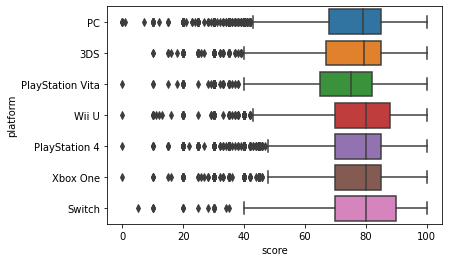

In [20]:
sns.boxplot(train_df["score"], train_df["platform"], orient="h");

In [24]:
sorted_game_dates = train_df.groupby("game")["date"].max().sort_values(ascending=False)

In [28]:
COLS_TO_DROP = [
    "name", "game", "platform", "date", "ID"
]

In [29]:
train_df.drop(columns=COLS_TO_DROP, inplace=True)
test_df.drop(columns=COLS_TO_DROP, inplace=True)

/home/imd/miniconda3/envs/mlisuct/lib/python3.8/site-packages/pandas/core/frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [31]:
train_df.head()

,review,score
1364,"Two Worlds is atmospheric and exiting, vast an...",70.0
1352,If you are looking for a really good role play...,91.0
1353,"Two Worlds 2 has lots of different quests, lot...",90.0
1356,Quotation forthcoming.,85.0
2596,"Still, Faery is commendable for being among th...",58.0


In [36]:
stem = SnowballStemmer("english")

In [39]:
lemma = WordNetLemmatizer()

In [43]:
stop_words = set(stopwords.words("english"))

In [47]:
stop_words.remove("no")

In [48]:
stop_words.remove("not")

In [58]:
BRACKETS_RE = re.compile(r"\[[^\]]*\]")
PUNK_RE = re.compile(r"[.,\"'#@$%:;* \t\n^/\\-]+")

def preprocessing(text):
    text = BRACKETS_RE.sub("", text)
    text = text.lower()
    text = text.replace("&", " and ")
    text = text.replace("n't", " not")
    text = text.replace("n'", " not")
    text = PUNK_RE.sub(" ", text)
    text_list = wordpunct_tokenize(text)
    text_list = [lemma.lemmatize(word) for word in text_list if word not in stop_words]
    text = " ".join(text_list)
    return text.strip()

In [59]:
train_df["review_proceed"] = train_df["review"].apply(preprocessing)
test_df["review_proceed"] = test_df["review"].apply(preprocessing)

/tmp/ipykernel_17901/1002323290.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["review_proceed"] = train_df["review"].apply(preprocessing)
/tmp/ipykernel_17901/1002323290.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["review_proceed"] = test_df["review"].apply(preprocessing)


In [60]:
train_df["review_proceed"]

1364     two world atmospheric exiting vast addictive p...
1352     looking really good role playing game keep str...
1353     two world 2 lot different quest lot multiplaye...
1356                                 quotation forthcoming
2596     still faery commendable among first foray core...
                               ...                        
46966    hack g u last recode lot love poured developme...
46970    hack g u last recode great attempt modernize o...
51792    really wanted bubsy woolies strike back good l...
43287    looking football simulation grab copy pe 2018 ...
46973    last recode high low overall think bundle grea...
Name: review_proceed, Length: 49740, dtype: object

In [72]:
pipe = Pipeline([
    ("vectorizer", CountVectorizer(ngram_range=(1, 2))),
    ("model", Ridge()),
])

In [73]:
COLS_TO_FIT = "review_proceed"
TARGET_COL = "score"

In [74]:
pipe.fit(train_df[COLS_TO_FIT], train_df[TARGET_COL])

Pipeline(steps=[('vectorizer', CountVectorizer(ngram_range=(1, 2))),
                ('model', Ridge())])

In [75]:
prediction = pipe.predict(test_df[COLS_TO_FIT])

In [76]:
mean_squared_error(test_df[TARGET_COL], prediction)

135.6887908757617

In [77]:
mean_absolute_error(test_df[TARGET_COL], prediction)

8.903250589766207

In [78]:
pipe = Pipeline([
    ("vectorizer", CountVectorizer(ngram_range=(1, 2), min_df=5)),
    ("model", Ridge()),
])

In [83]:
def train_and_validate(model, train_df, test_df):
    pipe.fit(train_df[COLS_TO_FIT], train_df[TARGET_COL])
    prediction = pipe.predict(test_df[COLS_TO_FIT])
    print(f"mse: {mean_squared_error(test_df[TARGET_COL], prediction):.3f}")
    print(f"mae: {mean_absolute_error(test_df[TARGET_COL], prediction):.3f}")

In [84]:
pipe = Pipeline([
    ("vectorizer", CountVectorizer(ngram_range=(1, 2), max_df=0.3)),
    ("model", Ridge()),
])

In [85]:
train_and_validate(pipe, train_df, test_df)

mse: 135.673
mae: 8.903


In [86]:
pipe = Pipeline([
    ("vectorizer", CountVectorizer(ngram_range=(1, 2), max_df=0.3)),
    ("model", Ridge(alpha=5)),
])

In [87]:
train_and_validate(pipe, train_df, test_df)

mse: 124.015
mae: 8.492


In [90]:
pipe = Pipeline([
    ("vectorizer", CountVectorizer(ngram_range=(1, 2), max_df=0.3, token_pattern=r"\S+")),
    ("model", Ridge(alpha=10)),
])

In [91]:
train_and_validate(pipe, train_df, test_df)

mse: 120.073
mae: 8.350


In [92]:
pipe = Pipeline([
    ("vectorizer", TfidfVectorizer(ngram_range=(1, 2), max_df=0.3, token_pattern=r"\S+")),
    ("model", Ridge(alpha=10)),
])

In [93]:
train_and_validate(pipe, train_df, test_df)

mse: 121.566
mae: 8.173


In [94]:
pipe = Pipeline([
    ("vectorizer", TfidfVectorizer(ngram_range=(1, 2), max_df=0.3, token_pattern=r"\S+")),
    ("model", Lasso(alpha=1)),
])

In [95]:
train_and_validate(pipe, train_df, test_df)

mse: 196.612
mae: 10.879


In [96]:
pipe = Pipeline([
    ("vectorizer", TfidfVectorizer(ngram_range=(1, 2), max_df=0.3, token_pattern=r"\S+", norm=False)),
    ("model", Ridge(alpha=10)),
])

In [97]:
train_and_validate(pipe, train_df, test_df)

mse: 139.139
mae: 9.015


In [ ]:
LogisticRegression(
    C=1.0, # исследовать, любые значения float
    penalty="l2", # исследовать l1, l2, elasticnet
    solver="saga" # не меняем
)

In [101]:
pipe = Pipeline([
    ("vectorizer", TfidfVectorizer(ngram_range=(2, 3), max_df=0.3, token_pattern=r"\S+")),
    ("model", Ridge(alpha=10)),
])

In [102]:
train_and_validate(pipe, train_df, test_df)

mse: 167.194
mae: 9.849
